Final Project 

In [1]:
# Imports
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import sklearn
from scipy.sparse import coo_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.nn.functional as Func
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score
import joblib
import pickle


import wandb

In [2]:
"""
Config File:
N_TRAIN  1699860
N_DEV    234376
D        13
C        61
"""
# Standardize method
scaler = StandardScaler()

# Grab Data, target,feature order
class Dataset():
    def __init__(self,targetFilename,featureFilename):
        traintarget = np.loadtxt(targetFilename, delimiter=" ")
        trainfeature = np.loadtxt(featureFilename,delimiter=" ")
        self.X = torch.tensor(trainfeature, dtype=torch.float32)
        self.y = torch.tensor(traintarget, dtype=torch.long)
    # Retrieve X and y based on index
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    # Size of Dataset
    def __len__(self):
        return len(self.X)
    
class TestDataset():
    def __init__(self, featureFilename):
        trainfeature = np.loadtxt(featureFilename,delimiter=" ")
        self.X = torch.tensor(trainfeature, dtype=torch.float32)
    # Retrieve X based on index
    def __getitem__(self, index):
        return self.X[index]
    # Size of Dataset
    def __len__(self):
        return len(self.X)

# Get a random Subset of data
def get_subset(X,y, subset_size):

    rows = X[:, 0].to(dtype = torch.int)
    cols = X[:, 1].to(dtype = torch.int)
    vals = X[:, 2]

    num_rows = rows.max() + 1
    num_cols = cols.max() + 1

    sparse_matrix = coo_matrix((vals, (rows, cols)), shape=(num_rows, num_cols))
    X_np_full = sparse_matrix.toarray()
    y_np_full = y.numpy()


    indices = torch.randperm(sparse_matrix.shape[0])[:subset_size]
    featureSubset = X_np_full[indices]
    targetSubset = y_np_full[indices]
    return featureSubset,targetSubset

In [3]:
# Load Data
train = Dataset("data/task5_beer/train.CT","data/task5_beer/train.sparseX")
dev = Dataset("data/task5_beer/dev.CT","data/task5_beer/dev.sparseX")
X_np,y_np = get_subset(train.X,train.y,182875)

scaler.fit(X_np)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [4]:
hidden_units = 256
input_dim = X_np.shape[1]
num_classes = len(np.unique(y_np))
epochs = 18
lr = 0.001
batch_size = 256
shuffle = True
optimizer = torch.optim.Adam
criterion = torch.nn.NLLLoss

# Deep Neural Network skorch
class DNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DNN, self).__init__()
        self.firstL = nn.Linear(input_dim, hidden_units)
        self.hiddenL = nn.Linear(hidden_units, hidden_units)
        self.hiddenL2 = nn.Linear(hidden_units, hidden_units)
        # self.hiddenL3 = nn.Linear(hidden_units, hidden_units)
        self.outL = nn.Linear(hidden_units, num_classes)

    def forward(self, x):
        x = Func.relu(self.firstL(x))
        x = Func.relu(self.hiddenL(x))
        x = Func.relu(self.hiddenL2(x))
        # x = Func.relu(self.hiddenL3(x))
        return Func.softmax(self.outL(x), dim=-1)

network = NeuralNetClassifier(DNN,
                              module__input_dim = input_dim,
                              module__num_classes = num_classes,
                              max_epochs = epochs,
                              lr = lr,
                              iterator_train__shuffle = shuffle,
                              batch_size = batch_size,
                              optimizer = optimizer,
                              criterion = criterion,
                              )


In [ ]:
wandb.init(
    project="Ml-Final_project",
    config={
        "model_type": "Deep Neural Network",
        "hidden_units": hidden_units,
        "input_dim": input_dim,
        "num_classes": num_classes,
        "epochs": epochs,
        "lr": lr,
        "shuffle": shuffle,
        "batch_size": batch_size,
        "optimizer": optimizer,
        "criterion": criterion,
        "hidden_layers": 2
    }
)

# train
scaler = joblib.load("scaler.pkl")
X_np_scaled = scaler.transform(X_np)
network.fit(X_np_scaled, y_np)

network.save_params(f_params='dnn_model.pt')

# Dev
# Convert dev sparse matrix to dense for sklearn
dev_rows = dev.X[:, 0].to(dtype=torch.int)
dev_cols = dev.X[:, 1].to(dtype=torch.int)
dev_vals = dev.X[:, 2]

num_rows = dev_rows.max() + 1
num_cols = int(train.X[:,1].max().item()) + 1 


dev_sparse_matrix = coo_matrix((dev_vals, (dev_rows, dev_cols)), shape=(num_rows, num_cols))
X_dev = dev_sparse_matrix.toarray()
X_dev = scaler.transform(X_dev)

y_dev = dev.y.numpy()

y_dev_pred = network.predict_proba(X_dev)
y_dev_labels = network.predict(X_dev)

dev_acc = accuracy_score(y_dev, y_dev_labels)
dev_loss = log_loss(y_dev, y_dev_pred)

recall = recall_score(y_dev, y_dev_labels, average = "macro")
precision = precision_score(y_dev, y_dev_labels, average = "macro")
f1 = f1_score(y_dev, y_dev_labels, average = "macro")


wandb.log({"loss": dev_loss, "accuracy": dev_acc, "recall": recall, "precision": precision, "f1-score": f1})

wandb.finish()

In [ ]:
wandb.init(
    project="Ml-Final_project",
    config={
        "model_type": "Random_Forests",
        "number_of_forests": 1,
        "n_estimators": 100, 
        "random_state": 4,
        # "max_depth": 15,
        "bootstrap": 'True',
        "oob_score": 'True'
    }
)

# Train random forest
rf1 = RandomForestClassifier(n_estimators=100, random_state=4, bootstrap=True, oob_score=True)

# train
scaler = joblib.load("scaler.pkl")
X_np_scaled = scaler.transform(X_np)
rf1.fit(X_np_scaled, y_np)

joblib.dump(rf1, 'randomForest.pkl', compress=('zlib', 9))

# Dev
# Convert dev sparse matrix to dense for sklearn
dev_rows = dev.X[:, 0].to(dtype=torch.int)
dev_cols = dev.X[:, 1].to(dtype=torch.int)
dev_vals = dev.X[:, 2]

num_rows = dev_rows.max() + 1
num_cols = int(train.X[:,1].max().item()) + 1 


dev_sparse_matrix = coo_matrix((dev_vals, (dev_rows, dev_cols)), shape=(num_rows, num_cols))
X_dev = dev_sparse_matrix.toarray()
X_dev = scaler.transform(X_dev)

y_dev = dev.y.numpy()

y_dev_pred = rf1.predict_proba(X_dev)
y_dev_labels = rf1.predict(X_dev)

dev_acc = accuracy_score(y_dev, y_dev_labels)
dev_loss = log_loss(y_dev, y_dev_pred)

recall = recall_score(y_dev, y_dev_labels, average = "macro")
precision = precision_score(y_dev, y_dev_labels, average = "macro")
f1 = f1_score(y_dev, y_dev_labels, average = "macro")


wandb.log({"loss": dev_loss, "accuracy": dev_acc, "recall": recall, "precision": precision, "f1-score": f1})

wandb.finish()

wandb: Currently logged in as: jordanvan92 (jordanvan92-western-washington-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'loss': 0.34051611071745314, 'accuracy': 0.9974791524265209, 'recall': 0.9976701715191162, 'precision': 0.997728495691101, 'f1-score': 0.9976970806141152}


c:\School_stuff\Western\CSCI\MCS471\final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


accuracy,▁
f1-score,▁
loss,▁
precision,▁
recall,▁
accuracy,0.4274
f1-score,0.32838
loss,3.87625
precision,0.50714
recall,0.27848


In [ ]:
learning_rate_init=0.001
early_stopping = True
alpha = 0.001
max_iter=500

wandb.init(
    project="Ml-Final_project",
    config={
        "model_type": "MLPClassifier",
        "mlp": [
            {"name": "mlp1", "hidden_layer_sizes":(150, 150, 150, 150), "activation": 'relu', "alpha": alpha, "learning_rate": learning_rate_init,
             "early_stopping": True, "max_iter": max_iter, "random_state": 1},
            {"name": "mlp2", "hidden_layer_sizes":(100, 100, 100, 100), "activation": 'relu', "alpha": alpha, "learning_rate": learning_rate_init,
             "early_stopping": True, "max_iter": max_iter, "random_state": 2},
            {"name": "mlp3", "hidden_layer_sizes":(50, 50, 50, 50), "activation": 'relu', "alpha": alpha, "learning_rate": learning_rate_init,
             "early_stopping": True, "max_iter": max_iter, "random_state": 3}
        ],
    }
)

mlp1 = MLPClassifier(hidden_layer_sizes = (150,150,150,150), activation = 'relu'
                       ,alpha = 0.001, learning_rate_init=0.001, early_stopping=True, max_iter=500, random_state=1)
mlp2 = MLPClassifier(hidden_layer_sizes = (100,100,100,100), activation = 'relu'
                       ,alpha = 0.001, learning_rate_init=0.001, early_stopping=True, max_iter=500, random_state=2)
mlp3 = MLPClassifier(hidden_layer_sizes = (50,50,50,50), activation = 'relu'
                       ,alpha = 0.01, learning_rate_init=0.001, early_stopping=True, max_iter=500, random_state=3)

ensemble2 = VotingClassifier(estimators=[
                                        ("mlp1", mlp1),
                                        ("mlp2", mlp2),
                                        ("mlp3", mlp3),
                                          ],
                                          voting="soft")

# train
scaler = joblib.load("scaler.pkl")
X_np_scaled = scaler.transform(X_np)
ensemble2.fit(X_np_scaled, y_np)

joblib.dump(ensemble2, 'mlp_ensemble.pkl')

# Dev
# Convert dev sparse matrix to dense for sklearn
dev_rows = dev.X[:, 0].to(dtype=torch.int)
dev_cols = dev.X[:, 1].to(dtype=torch.int)
dev_vals = dev.X[:, 2]

num_rows = dev_rows.max() + 1
num_cols = int(train.X[:,1].max().item()) + 1 


dev_sparse_matrix = coo_matrix((dev_vals, (dev_rows, dev_cols)), shape=(num_rows, num_cols))
X_dev = dev_sparse_matrix.toarray()
X_dev = scaler.transform(X_dev)

y_dev = dev.y.numpy()

y_dev_pred = ensemble2.predict_proba(X_dev)
y_dev_labels = ensemble2.predict(X_dev)

dev_acc = accuracy_score(y_dev, y_dev_labels)
dev_loss = log_loss(y_dev, y_dev_pred)

recall = recall_score(y_dev, y_dev_labels, average = "macro")
precision = precision_score(y_dev, y_dev_labels, average = "macro")
f1 = f1_score(y_dev, y_dev_labels, average = "macro")


wandb.log({"loss": dev_loss, "accuracy": dev_acc, "recall": recall, "precision": precision, "f1-score": f1})

wandb.finish()

In [ ]:
# XGBoost
booster = 'gbtree'
n_estimators = 400
lr = 0.001
max_depth = 7
sub_sample = 0.8
colsample_bytree = 0.8
objective = 'multi:softprob'
eval_metric = 'mlogloss'
num_classes = len(np.unique(y_np))

wandb.init(
    project="Ml-Final_project",
    config={
        "model_type": "XGBoost",
        "booster": booster,
        "lr": lr,
        "max_depth": max_depth,
        "sub_sample": sub_sample,
        "colsample_bytree": colsample_bytree,
        "objective": objective,
        "eval_metric": eval_metric,
        "num_class": num_classes,
        "n_estimators": n_estimators
    }
)

params = {
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': num_classes,
    'n_estimators': n_estimators
}

xgb = XGBClassifier(**params)

# train
scaler = joblib.load("scaler.pkl")
X_np_scaled = scaler.transform(X_np)
xgb.fit(X_np_scaled, y_np)

joblib.dump(xgb, 'xgboost.pkl')

# Dev
# Convert dev sparse matrix to dense for sklearn
dev_rows = dev.X[:, 0].to(dtype=torch.int)
dev_cols = dev.X[:, 1].to(dtype=torch.int)
dev_vals = dev.X[:, 2]

num_rows = dev_rows.max() + 1
num_cols = int(train.X[:,1].max().item()) + 1 


dev_sparse_matrix = coo_matrix((dev_vals, (dev_rows, dev_cols)), shape=(num_rows, num_cols))
X_dev = dev_sparse_matrix.toarray()
X_dev = scaler.transform(X_dev)

y_dev = dev.y.numpy()

y_dev_pred = xgb.predict_proba(X_dev)
y_dev_labels = xgb.predict(X_dev)

dev_acc = accuracy_score(y_dev, y_dev_labels)
dev_loss = log_loss(y_dev, y_dev_pred)

recall = recall_score(y_dev, y_dev_labels, average = "macro")
precision = precision_score(y_dev, y_dev_labels, average = "macro")
f1 = f1_score(y_dev, y_dev_labels, average = "macro")


wandb.log({"loss": dev_loss, "accuracy": dev_acc, "recall": recall, "precision": precision, "f1-score": f1})

wandb.finish()


In [ ]:
# Ensembling
rf_trained = joblib.load('randomForest.pkl')
xgb_trained = joblib.load('xgboost.pkl')
mlp_ensemble_trained = joblib.load('mlp_ensemble.pkl')

net_trained = NeuralNetClassifier(DNN,
                                module__input_dim = input_dim,
                                module__num_classes = num_classes,
                                max_epochs = epochs,
                                lr = lr,
                                iterator_train__shuffle = shuffle,
                                batch_size = batch_size,
                                optimizer = optimizer,
                                criterion = criterion
                                )
net_trained.initialize()
net_trained.load_params(f_params="dnn_model.pt")

wandb.init(
    project="Ml-Final_project",
    config={
        "model_type": "Ensembling",
        "xgboost": "XGBoost",
        "mlp": "MLPClassifier",
        "rf": "RandomForestClassifier",
        "dnn": "NeuralNetClassifier"

    }
)

# Dev
# Convert dev sparse matrix to dense for sklearn
dev_rows = dev.X[:, 0].to(dtype=torch.int)
dev_cols = dev.X[:, 1].to(dtype=torch.int)
dev_vals = dev.X[:, 2]

num_rows = dev_rows.max() + 1
num_cols = int(train.X[:,1].max().item()) + 1 


dev_sparse_matrix = coo_matrix((dev_vals, (dev_rows, dev_cols)), shape=(num_rows, num_cols))
X_dev = dev_sparse_matrix.toarray()

scaler = joblib.load("scaler.pkl")
X_dev = scaler.transform(X_dev)

xgb_probs = xgb_trained.predict_proba(X_dev)
mlp_probs = mlp_ensemble_trained.predict_proba(X_dev)
rf_probs = rf_trained.predict_proba(X_dev)
dnn_probs = net_trained.predict_proba(X_dev)

ensemble = (
    5*rf_probs + 
    2*xgb_probs +
    2*mlp_probs +
    1*dnn_probs
) / 10

y_dev = dev.y.numpy()

y_dev_pred = ensemble
y_dev_labels = np.argmax(ensemble, axis=1)

dev_acc = accuracy_score(y_dev, y_dev_labels)
dev_loss = log_loss(y_dev, y_dev_pred)

recall = recall_score(y_dev, y_dev_labels, average = "macro")
precision = precision_score(y_dev, y_dev_labels, average = "macro")
f1 = f1_score(y_dev, y_dev_labels, average = "macro")


wandb.log({"loss": dev_loss, "accuracy": dev_acc, "recall": recall, "precision": precision, "f1-score": f1})

wandb.finish()


wandb: Currently logged in as: jordanvan92 (jordanvan92-western-washington-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


c:\School_stuff\Western\CSCI\MCS471\final\venv\Lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\School_stuff\Western\CSCI\MCS471\final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


accuracy,▁
f1-score,▁
loss,▁
precision,▁
recall,▁
accuracy,0.46887
f1-score,0.3705
loss,1.95691
precision,0.53121
recall,0.32565


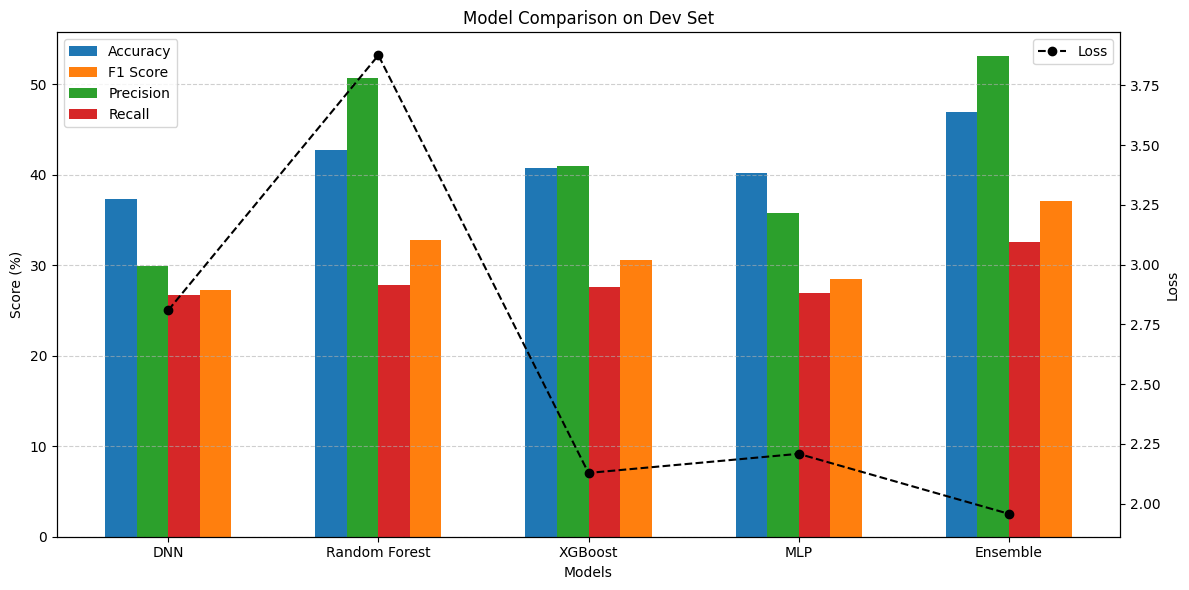

In [ ]:
# Bar Chart
models = ['DNN', 'Random Forest', 'XGBoost', 'MLP', 'Ensemble']
accuracy = [0.373, 0.427, 0.408, 0.402, 0.469]
f1_score = [0.273, 0.328, 0.306, 0.285, 0.371]
loss = [2.809, 3.876, 2.128, 2.208, 1.957]
precision = [0.299, 0.507, 0.410, 0.358, 0.531]
recall = [0.267, 0.278, 0.276, 0.269, 0.326]

# Convert accuracy-like metrics to percentages
accuracy = [x * 100 for x in accuracy]
f1_score = [x * 100 for x in f1_score]
precision = [x * 100 for x in precision]
recall = [x * 100 for x in recall]

x = np.arange(len(models))
width = 0.15

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for accuracy, precision, recall, f1
ax1.bar(x - 1.5*width, accuracy, width, label='Accuracy')
ax1.bar(x + 1.5*width, f1_score, width, label='F1 Score')
ax1.bar(x - 0.5*width, precision, width, label='Precision')
ax1.bar(x + 0.5*width, recall, width, label='Recall')

ax1.set_ylabel('Score (%)')
ax1.set_xlabel('Models')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title('Model Comparison on Dev Set')
ax1.legend(loc='upper left')
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)

# Secondary axis for loss
ax2 = ax1.twinx()
ax2.plot(x, loss, 'o--', color='black', label='Loss')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

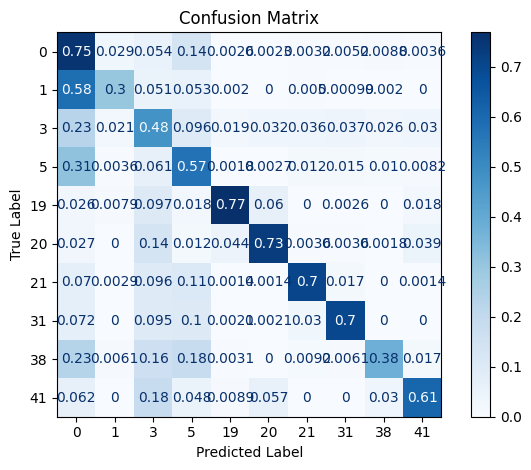

In [ ]:
from collections import Counter
# Gets top 10
top_k = 10
top_labels = [label for label, _ in Counter(y_dev).most_common(top_k)]
mask = [y in top_labels for y in y_dev]

filtered_true = np.array(y_dev)[mask]
filtered_pred = np.array(y_dev_labels)[mask]
filtered_labels = sorted(set(top_labels))

# Confusion Matrix
cm = confusion_matrix(filtered_true, filtered_pred, labels = filtered_labels, normalize='true')
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=filtered_labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()

In [5]:
# Test set
rf_trained = joblib.load('randomForest.pkl')
xgb_trained = joblib.load('xgboost.pkl')
mlp_ensemble_trained = joblib.load('mlp_ensemble.pkl')

net_trained = NeuralNetClassifier(DNN,
                                module__input_dim = input_dim,
                                module__num_classes = num_classes,
                                max_epochs = epochs,
                                lr = lr,
                                iterator_train__shuffle = shuffle,
                                batch_size = batch_size,
                                optimizer = optimizer,
                                criterion = criterion
                                )
net_trained.initialize()
net_trained.load_params(f_params="dnn_model.pt")

test = TestDataset("test_features/task5/test.sparseX")
# Test
# Convert test sparse matrix to dense for sklearn
test_rows = test.X[:, 0].to(dtype=torch.int)
test_cols = test.X[:, 1].to(dtype=torch.int)
test_vals = test.X[:, 2]

num_rows = test_rows.max() + 1
num_cols = int(train.X[:,1].max().item()) + 1 


test_sparse_matrix = coo_matrix((test_vals, (test_rows, test_cols)), shape=(num_rows, num_cols))
X_test = test_sparse_matrix.toarray()

scaler = joblib.load("scaler.pkl")
X_test = scaler.transform(X_test)

xgb_probs = xgb_trained.predict_proba(X_test)
mlp_probs = mlp_ensemble_trained.predict_proba(X_test)
rf_probs = rf_trained.predict_proba(X_test)
dnn_probs = net_trained.predict_proba(X_test)

ensemble = (
    5*rf_probs + 
    2*xgb_probs +
    2*mlp_probs +
    1*dnn_probs
) / 10


y_pred = ensemble
y_labels = np.argmax(ensemble, axis=1)


submission = pd.DataFrame(y_labels)
submission.to_csv("task5.predictions", index=False)